In [1]:
#Mounting my google drive

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [5]:
%env CUDA_VISIBLE_DEVICES

'0'

# **Car Classification**

**Motivation**

Our goal is to build a classifier that can predict different Make, Model, Year of cars, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe. We used [Stanford Cars Dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html) for this purpose. The Cars dataset contains 16,185 images of 196 classes of cars.




In [0]:
import matplotlib.pyplot as plt
from PIL import Image
import glob
from scipy.io import loadmat
import tarfile
import scipy.io
import numpy as np
import cv2 as cv
import os
import shutil
import random
from fastai.vision import *
from fastai.metrics import error_rate


**Assembling data**

The [Stanford Cars Dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html) is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe. I dowloaded the training and test dataset and visualized few images from both training and test folders. Next I downloaded the metadata (a devkit, including class labels for training images and bounding boxes for all images) and looked at the different class labels.

In [0]:
# import os
# os.chgdir('/where/you/want/to/work')

In [0]:
# Downloading training images
!wget -cq http://imagenet.stanford.edu/internal/car196/cars_train.tgz

In [0]:
# Extracting training images 
!tar xvf cars_train.tgz 

In [0]:
# Dowloading test images
!wget -cq http://imagenet.stanford.edu/internal/car196/cars_test.tgz

In [0]:
# Extracting test images
!tar xvf cars_test.tgz 

In [14]:
# Displaying a few training images
count=0
fig=plt.figure(figsize=(16, 9))
for filename in glob.glob('cars_train/*.jpg'):
    img=Image.open(filename)
    count = count+1
    fig.add_subplot(3, 3, count)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    plt.imshow(img)
    plt.title(filename)
    print (filename)
    if count==9:
      break
      

AttributeError: ignored

<Figure size 1152x648 with 0 Axes>

cars_test/00169.jpg
cars_test/04261.jpg
cars_test/02637.jpg
cars_test/02759.jpg
cars_test/00288.jpg
cars_test/00049.jpg
cars_test/01354.jpg
cars_test/02776.jpg
cars_test/03433.jpg


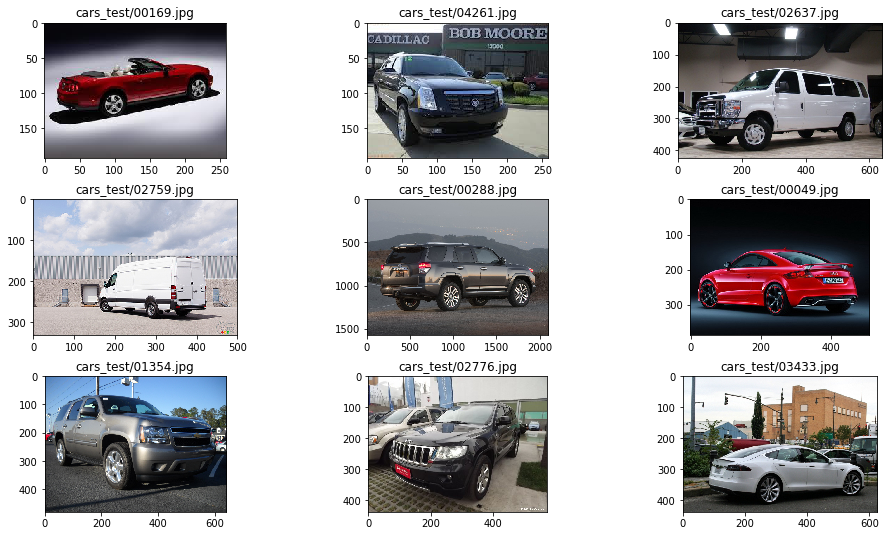

In [0]:
# Displaying a few test images
count=0
fig=plt.figure(figsize=(16, 9))
for filename in glob.glob('cars_test/*.jpg'):
    img=Image.open(filename)
    count = count+1
    fig.add_subplot(3, 3, count)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    plt.imshow(img)
    plt.title(filename)
    print (filename)
    if count==9:
      break
      

In [0]:
# Downloading devkit that includes class labels for training images and bounding boxes for all image
!wget -cq https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz

In [0]:
# Extracting devkit
!tar xvf car_devkit.tgz 

devkit/
devkit/cars_meta.mat
devkit/cars_train_annos.mat
devkit/cars_test_annos.mat
devkit/README.txt
devkit/train_perfect_preds.txt
devkit/eval_train.m


In [10]:
# Looking at different class labels
x = loadmat('devkit/cars_meta.mat')
x

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Dec 14 14:13:07 2013',
 '__version__': '1.0',
 'class_names': array([[array(['AM General Hummer SUV 2000'], dtype='<U26'), array(['Acura RL Sedan 2012'], dtype='<U19'),
         array(['Acura TL Sedan 2012'], dtype='<U19'), array(['Acura TL Type-S 2008'], dtype='<U20'), ...,
         array(['Volvo C30 Hatchback 2012'], dtype='<U24'), array(['Volvo 240 Sedan 1993'], dtype='<U20'),
         array(['Volvo XC90 SUV 2007'], dtype='<U19'), array(['smart fortwo Convertible 2012'], dtype='<U29')]],
       dtype=object)}

This portion of the code is taken from Andrew's notebook. It deals with cropping the images and organizing them into train and valid folders and by their class. Ali modified it to label the images by the name of the label instead of the class id.

In [0]:

def save_train_data(fnames, labels, bboxes):
    src_folder = 'cars_train'
    num_samples = len(fnames)
    
    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)
    
    
    for i in range(num_samples):
        fname = fnames[i]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]
        
        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        
        margin = 16
        x1 = max(0, x1-margin)
        y1 = max(0, y1-margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        
        if i in train_indexes:
            dst_folder = 'train'
        else:
            dst_folder = 'valid'
            
        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)
        
        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)
        
    print("All train data saved.") 
        
def save_test_data(fnames, bboxes):
    src_folder = 'cars_test'
    dst_folder = 'test'
    num_samples = len(fnames)
    
    for i in range(num_samples):
        fname = fnames[i]
        (x1, y1, x2, y2) = bboxes[i]
        
        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        
        margin = 16
        x1 = max(0, x1-margin)
        y1 = max(0, y1-margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        
        dst_path = os.path.join(dst_folder, fname)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)
      
    print("All test data saved.") 
        
def process_train_data():
    cars_annos = scipy.io.loadmat('devkit/cars_train_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)
    
    fnames = []
    class_ids = []
    bboxes = []
    labels = []
    
    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        labels.append('{}'.format(class_names[class_id-1][0][0]))
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        class_ids.append(class_id)
        fnames.append(fname)
        
    labels_count = np.unique(class_ids).shape[0]
    print('car count: %d' % labels_count)
    
    save_train_data(fnames, labels, bboxes)
    
def process_test_data():
    cars_annos = scipy.io.loadmat('devkit/cars_test_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)
    
    fnames = []
    bboxes = []
    
    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        fname = annotation[0][4][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        fnames.append(fname)
        
    save_test_data(fnames, bboxes)

In [17]:
cars_meta = scipy.io.loadmat('devkit/cars_meta')
class_names = cars_meta['class_names']
class_names = np.transpose(class_names)

img_width, img_height = 224, 224

process_train_data()
process_test_data()

car count: 196


AttributeError: ignored

**View Data**

I created a DataBunch. I used default data augmentations of fastai and noramalized the images with imagenet_stats. I took a look at the classes and also a few cropped images.

In [0]:
basedir='gdrive/My Drive/Colab Notebooks'

In [0]:
data = ImageDataBunch.from_folder('.', ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [19]:
data.classes

['AM General Hummer SUV 2000',
 'Acura Integra Type R 2001',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012',
 'Aston Martin Virage Convertible 2012',
 'Aston Martin Virage Coupe 2012',
 'Audi 100 Sedan 1994',
 'Audi 100 Wagon 1994',
 'Audi A5 Coupe 2012',
 'Audi R8 Coupe 2012',
 'Audi RS 4 Convertible 2008',
 'Audi S4 Sedan 2007',
 'Audi S4 Sedan 2012',
 'Audi S5 Convertible 2012',
 'Audi S5 Coupe 2012',
 'Audi S6 Sedan 2011',
 'Audi TT Hatchback 2011',
 'Audi TT RS Coupe 2012',
 'Audi TTS Coupe 2012',
 'Audi V8 Sedan 1994',
 'BMW 1 Series Convertible 2012',
 'BMW 1 Series Coupe 2012',
 'BMW 3 Series Sedan 2012',
 'BMW 3 Series Wagon 2012',
 'BMW 6 Series Convertible 2007',
 'BMW ActiveHybrid 5 Sedan 2012',
 'BMW M3 Coupe 2012',
 'BMW M5 Sedan 2010',
 'BMW M6 Convertible 2010',
 'BMW X3 SUV 2012',
 'BMW X5 SUV 2007',
 'BMW X6

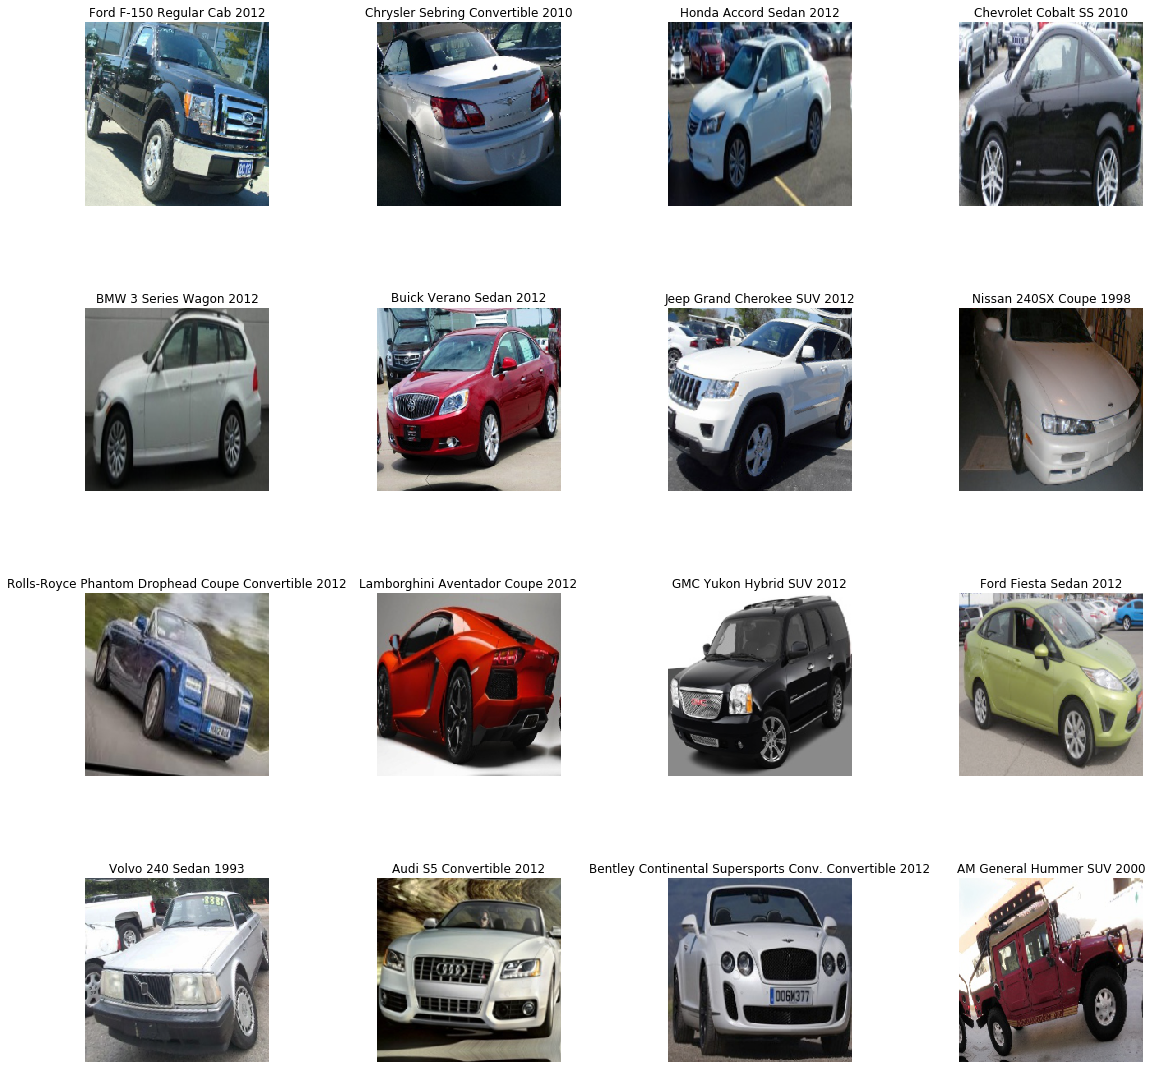

In [20]:
data.show_batch(rows=4)

**Training: resnet34**

The very first model that I used is resnet34. I trained for 8 epochs and the error rate came to be 38%. So, I thought of moving to resnet50.

In [21]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 83577907.30it/s]


In [22]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,5.796721,4.994452,0.955367,00:35
1,4.824809,3.772313,0.815090,00:36
2,3.756516,2.965734,0.687566,00:35
3,2.867449,2.500615,0.602551,00:36
4,2.204700,2.257641,0.560043,00:34
5,1.748225,2.111706,0.521785,00:36
6,1.440794,2.068258,0.529224,00:36
7,1.291431,2.062954,0.526036,00:35


In [0]:
# saving the first model
learn.save('stage-1')

**Training: resnet50**

I trained this model for 10 epochs and the error rate was 29%.

In [24]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:04<00:00, 20987524.40it/s]


In [25]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,5.548433,4.657583,0.926674,00:43
1,4.504503,3.595529,0.775770,00:42
2,3.471068,2.930291,0.702444,00:42
3,2.561832,2.305969,0.579171,00:41
4,1.851444,2.050549,0.523911,00:40
5,1.314635,1.852433,0.470776,00:40
6,0.989988,1.752432,0.445271,00:41
7,0.731046,1.681641,0.432519,00:40
8,0.584226,1.642914,0.426142,00:42
9,0.520501,1.635181,0.425080,00:41


In [0]:
# saving the second model
learn.save('stage-2')

**Results**

I took a look at which were the categories that the model most confused with one another. But since the classes are the ids instead of actual labels, it's hard to interpret. I will fix this issue next week.

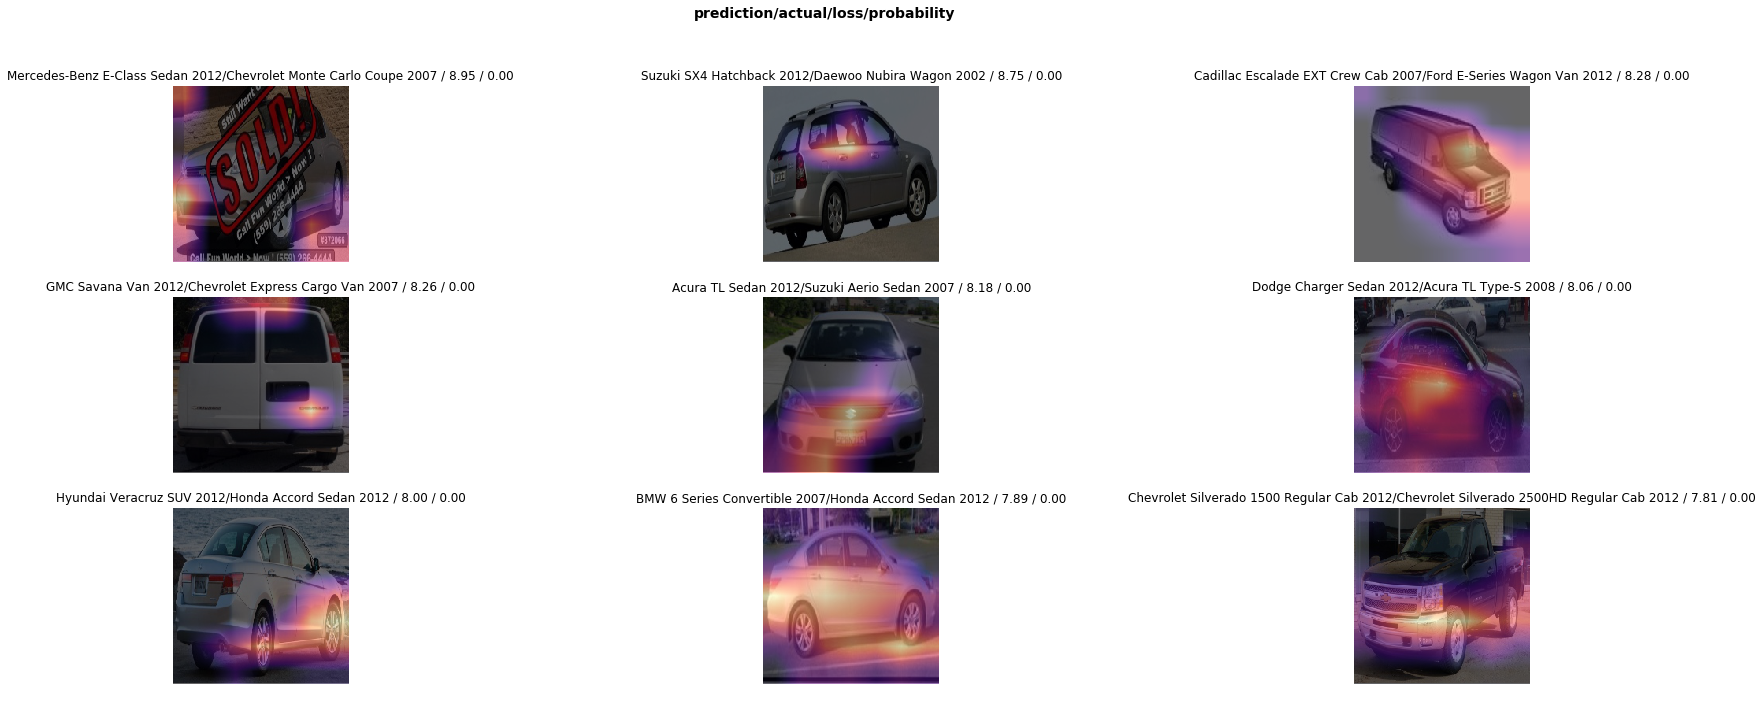

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(30,11))

In [31]:
interp.most_confused(min_val=2)

[('Chevrolet Express Cargo Van 2007', 'GMC Savana Van 2012', 5),
 ('Audi TTS Coupe 2012', 'Audi TT Hatchback 2011', 3),
 ('Chevrolet Express Van 2007', 'GMC Savana Van 2012', 3),
 ('Chevrolet Silverado 1500 Hybrid Crew Cab 2012',
  'Chevrolet Silverado 1500 Extended Cab 2012',
  3),
 ('Dodge Caliber Wagon 2007', 'Dodge Caliber Wagon 2012', 3),
 ('Dodge Sprinter Cargo Van 2009', 'Mercedes-Benz Sprinter Van 2012', 3),
 ('Ferrari California Convertible 2012',
  'Ferrari 458 Italia Convertible 2012',
  3),
 ('HUMMER H2 SUT Crew Cab 2009', 'HUMMER H3T Crew Cab 2010', 3),
 ('Rolls-Royce Phantom Sedan 2012', 'Rolls-Royce Ghost Sedan 2012', 3),
 ('Spyker C8 Coupe 2009', 'Spyker C8 Convertible 2009', 3),
 ('Aston Martin V8 Vantage Convertible 2012',
  'Aston Martin V8 Vantage Coupe 2012',
  2),
 ('Audi 100 Wagon 1994', 'Audi 100 Sedan 1994', 2),
 ('Audi A5 Coupe 2012', 'Audi S6 Sedan 2011', 2),
 ('Audi S4 Sedan 2012', 'Audi A5 Coupe 2012', 2),
 ('Audi TT RS Coupe 2012', 'Audi TT Hatchback 2011'

**Unfreezing and fine-tuning**

I fine tuned my resnet50 model and achieved an accuracy of ~89%.


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


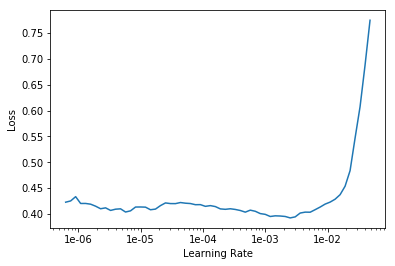

In [0]:

learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(9, max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.851354,1.761909,0.446286,01:15
1,2.033949,3.336376,0.688152,01:14
2,1.892949,1.794551,0.448742,01:14
3,1.304008,1.388843,0.374463,01:15
4,0.916510,1.028185,0.273788,01:15
5,0.611947,0.727831,0.200737,01:15
6,0.344807,0.534209,0.144260,01:15
7,0.192858,0.453782,0.121547,01:15
8,0.125551,0.432757,0.114180,01:16


In [0]:
learn.save('stage-3')

**Conclusion**

I achieved an accuracy of ~89% which I think is reasonably good considering the huge number of classes (196). The accuracy for the state of art architecture so far for classifying this dataset is ~94%. The next steps of this project will be to collaborate with all team members and focus on improving the accuracy of the model. Our aim will be to beat the accuracy of the state of art architecture. 